### 1. Train the Two Tower network

In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib inline

from utils.utils import *
from utils.utils_train import *
os.environ["TOKENIZERS_PARALLELISM"] = "false"  # Suppress huggingface warning

### Load Embeddings

In [2]:
# Load data
queries, query_embeddings, product_embeddings = load_raw_queries()

# load ids_toys from disk
with open('output/ids_toys.pkl', 'rb') as file:
    ids_toys = pickle.load(file)
    print(len(ids_toys))
    ids_present = [_id for _id in ids_toys if _id in query_embeddings]

# Assemble qb & xb input embeddings
qb = torch.stack([torch.tensor(query_embeddings[_id]) for _id in ids_present])
xb = torch.tensor(np.array([product_embeddings[_id] for _id in ids_present]))

### Split Dataset into Train and Test Sets
(qb_train, qb_test), (xb_train, xb_test), (idx_train, idx_test) = shuffle_and_split(qb, xb)
print('qb_train.shape:', qb_train.shape)
print('qb_test.shape:', qb_test.shape)


loaded (queries, query_embeddings, product_embeddings) from  output/raw_queries.pkl
84373
qb_train.shape: torch.Size([20560, 768])
qb_test.shape: torch.Size([5140, 768])


### Two-Tower Pytorch Model

In [3]:
d = hidden_dim = qb.shape[-1]
learning_rate = 0.0001

# Initialize the network
model = TwoTowerNetwork(d, hidden_dim, learning_rate=learning_rate)


recall@3  = 0.016                    
recall@3  = 0.016                    
recall@3  = 0.041                    
recall@3  = 0.066                    
recall@3  = 0.062                    
recall@3  = 0.041                    
recall@3  = 0.049                    
recall@3  = 0.073                    
recall@3  = 0.089                    
recall@3  = 0.088                    
recall@3  = 0.087                    
recall@3  = 0.094                    
recall@3  = 0.107                    
recall@3  = 0.127                    
recall@3  = 0.132                    
recall@3  = 0.134                    
recall@3  = 0.152                    
recall@3  = 0.171                    
recall@3  = 0.182                    
recall@3  = 0.197                    


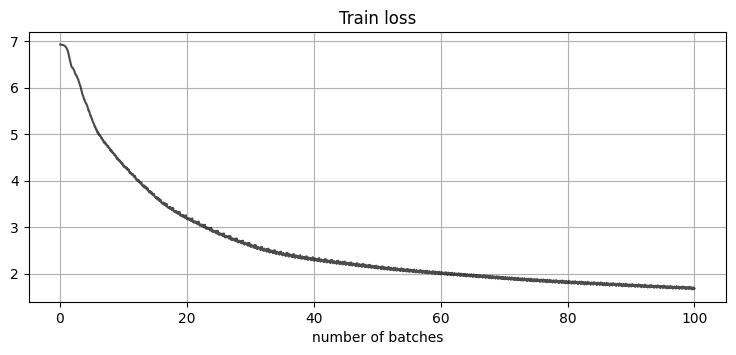

In [4]:
## TRAIN
import torch
import torch.nn as nn

# Hyperparameters
num_epochs = 5
batch_size = 1024

for i in range(20):
    model.train(qb_train, xb_train, num_epochs=num_epochs, batch_size=batch_size)
    write_output_embeddings(model, qb_test, xb_test) 
    # print(f"epoch no:{model.epochs[-1]:.0f}  ", end='')
    os.system('cd utils && python3 utils_infer.py')

model.plot(qb_train, batch_size)


In [ ]:
recall@3  = 0.016                    
recall@3  = 0.066                    
recall@3  = 0.041                    
recall@3  = 0.073                    
recall@3  = 0.088                    
recall@3  = 0.094                    
recall@3  = 0.127                    
recall@3  = 0.134                    
recall@3  = 0.171                    
recall@3  = 0.197                    
recall@3  = 0.209                    
recall@3  = 0.229                    
recall@3  = 0.270                    
recall@3  = 0.280                    
recall@3  = 0.274                    
recall@3  = 0.282                    
recall@3  = 0.308                    
recall@3  = 0.298                    
recall@3  = 0.326                    
recall@3  = 0.361     


### The End

In [3]:
# Load queries, ids_toys, ids_present
with open('output/raw_queries.pkl', 'rb') as file:
    queries, _, _ = pickle.load(file)

with open('output/ids_toys.pkl', 'rb') as file:
    ids_toys = pickle.load(file)
    ids_present = [_id for _id in ids_toys if _id in query_embeddings]


84373


In [5]:
top_ids = [ids_present[idx_test[i]] for i in I[0]]
names = [info[_id]['name'] for _id in top_ids]
details = [info[_id]['details'] for _id in top_ids]
description = [info[_id]['description'] for _id in top_ids]
queries[ids_present[idx_test[0]]]

"I need to buy a Super-duper Tutu/Cape/Mask set in size 4-6 for my 4-6-year-old. It's a 3-piece set perfect for little Superheroines and Rock Stars!"